In [1]:
#install libraries
!pip install datasets
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 6.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-

In [2]:
# import libraries
from datasets import load_dataset
from transformers import AutoTokenizer

import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report

from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import pyarrow as pa
from datasets import Dataset
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Load datasets
train_dataset = load_dataset("tweet_eval", "emotion", split="train")
valid_dataset = load_dataset("tweet_eval", "emotion", split="validation")
test_dataset = load_dataset("tweet_eval", "emotion", split="test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/3257 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1421 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/374 [00:00<?, ? examples/s]

In [4]:
# @title SVM Results
# SVM RESULTS

def accuracy_pred(X,y,type,model,model_type):
  y_pred = model.predict(X)
  accuracy = accuracy_score(y, y_pred)
  print(f"**************{type}*************")
  print(f"Accuracy of {type}:", accuracy)
  print(classification_report(y, y_pred))
  conf_matrix=confusion_matrix(y, y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  plt.show()

**************Train*************
Accuracy of Train: 0.9281547436291065
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      1400
           1       0.96      0.93      0.95       708
           2       0.99      0.69      0.82       294
           3       0.95      0.91      0.93       855

    accuracy                           0.93      3257
   macro avg       0.95      0.88      0.91      3257
weighted avg       0.93      0.93      0.93      3257



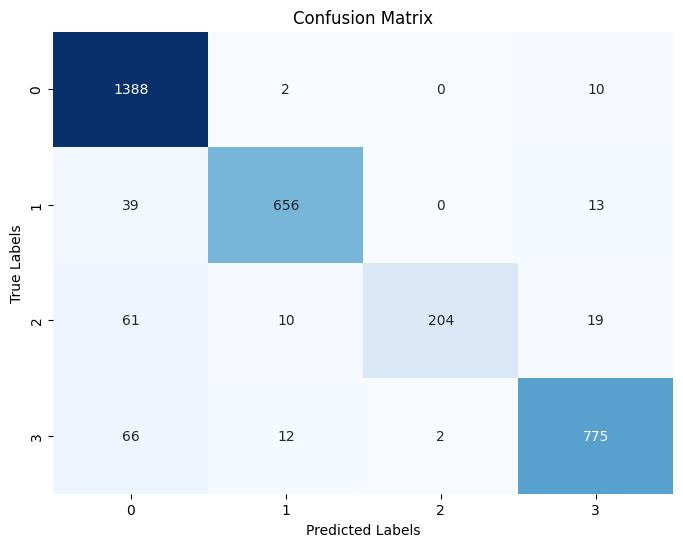

**************Validation*************
Accuracy of Validation: 0.6203208556149733
              precision    recall  f1-score   support

           0       0.61      0.81      0.70       160
           1       0.69      0.46      0.56        97
           2       0.50      0.29      0.36        28
           3       0.61      0.55      0.58        89

    accuracy                           0.62       374
   macro avg       0.60      0.53      0.55       374
weighted avg       0.62      0.62      0.61       374



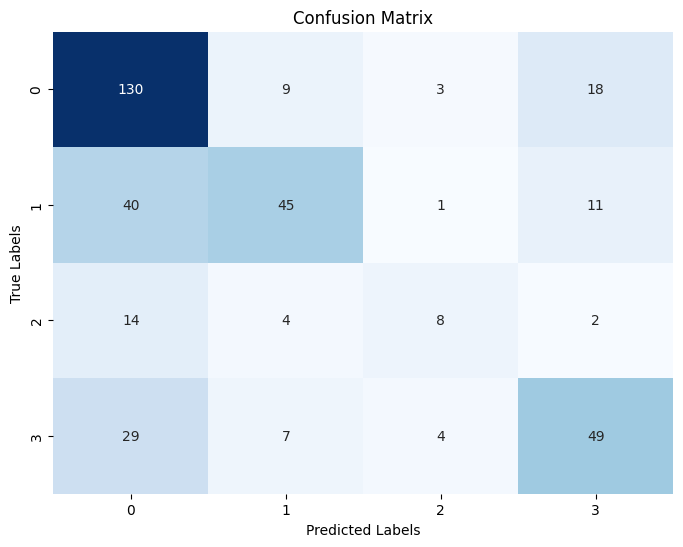

**************Test*************
Accuracy of Test: 0.6600985221674877
              precision    recall  f1-score   support

           0       0.62      0.89      0.73       558
           1       0.74      0.53      0.62       358
           2       0.65      0.21      0.32       123
           3       0.71      0.59      0.64       382

    accuracy                           0.66      1421
   macro avg       0.68      0.56      0.58      1421
weighted avg       0.68      0.66      0.64      1421



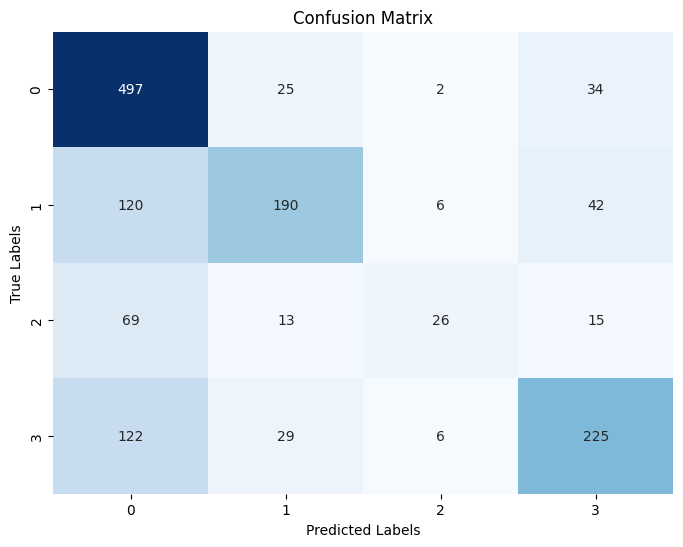

In [5]:
# @title SVM Model

# SVM Model
tfidf_vectorizer = TfidfVectorizer(max_features=10000)  # vectorize input data
X_train = tfidf_vectorizer.fit_transform(train_dataset['text'])
X_valid = tfidf_vectorizer.transform(valid_dataset['text'])
X_test = tfidf_vectorizer.transform(test_dataset['text'])
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, train_dataset['label'])
data=[X_train,X_valid,X_test]
type=['Train','Validation','Test']
labels=[train_dataset['label'],valid_dataset['label'],test_dataset['label']]
for i in range(3):
  accuracy_pred(data[i],labels[i],type[i],svm_classifier,'svm')


In [6]:
# @title Preprocessing train and validation data for BERT

#Initialize tokenizer and preprocess data
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
def process_data(row):

    text = row['text']
    text = str(text)
    text = ' '.join(text.split())
    encodings = tokenizer(text, padding="max_length", truncation=True, max_length=128)
    encodings['label'] = row['label']
    encodings['text'] = text
    return encodings

train_processed_data = []
valid_processed_data=[]
for i in train_dataset:
    train_processed_data.append(process_data(i))
for i in valid_dataset:
  valid_processed_data.append(process_data(i))

#Conversion to required format
train_d = pd.DataFrame(train_processed_data)
valid_d= pd.DataFrame(valid_processed_data)
train_hg = Dataset(pa.Table.from_pandas(train_d))
valid_hg = Dataset(pa.Table.from_pandas(valid_d))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [7]:
# @title BERT Model

#loading model
model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=4,

)

# initialized trainer
training_args = TrainingArguments(output_dir="./result", evaluation_strategy="epoch")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_hg,
    eval_dataset=valid_hg,
    tokenizer=tokenizer
)

#begin training
trainer.train()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.636629
2,0.710400,0.741795
3,0.316300,1.006315


TrainOutput(global_step=1224, training_loss=0.4444263339821809, metrics={'train_runtime': 145.8309, 'train_samples_per_second': 67.002, 'train_steps_per_second': 8.393, 'total_flos': 642726071829504.0, 'train_loss': 0.4444263339821809, 'epoch': 3.0})

**************Train*************
Accuracy of Train: 0.9821922014123426
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1400
           1       0.99      0.99      0.99       708
           2       0.97      0.97      0.97       294
           3       0.97      0.97      0.97       855

    accuracy                           0.98      3257
   macro avg       0.98      0.98      0.98      3257
weighted avg       0.98      0.98      0.98      3257



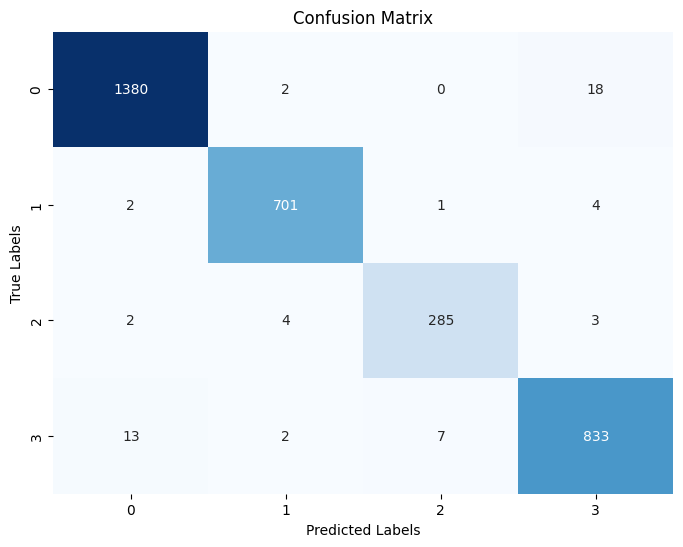

**************Validation*************
Accuracy of Validation: 0.7967914438502673
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       160
           1       0.82      0.73      0.77        97
           2       0.47      0.54      0.50        28
           3       0.74      0.82      0.78        89

    accuracy                           0.80       374
   macro avg       0.73      0.74      0.73       374
weighted avg       0.80      0.80      0.80       374



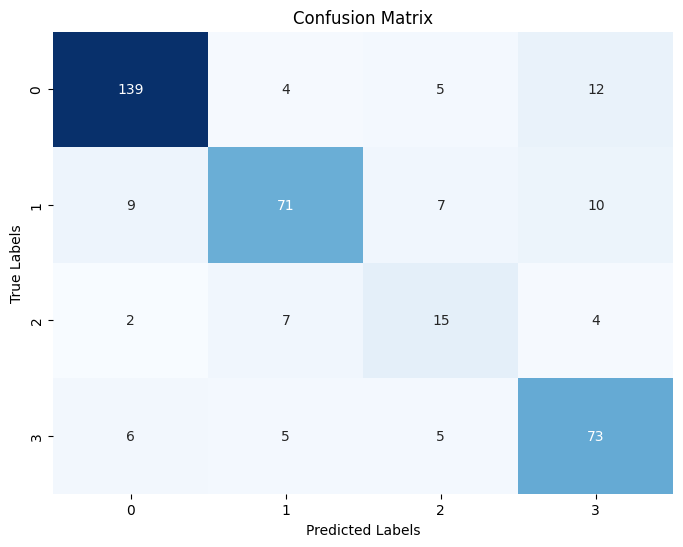

**************test*************
Accuracy of test: 0.8064743138634765
              precision    recall  f1-score   support

           0       0.88      0.81      0.84       558
           1       0.83      0.82      0.83       358
           2       0.67      0.71      0.69       123
           3       0.74      0.82      0.78       382

    accuracy                           0.81      1421
   macro avg       0.78      0.79      0.78      1421
weighted avg       0.81      0.81      0.81      1421



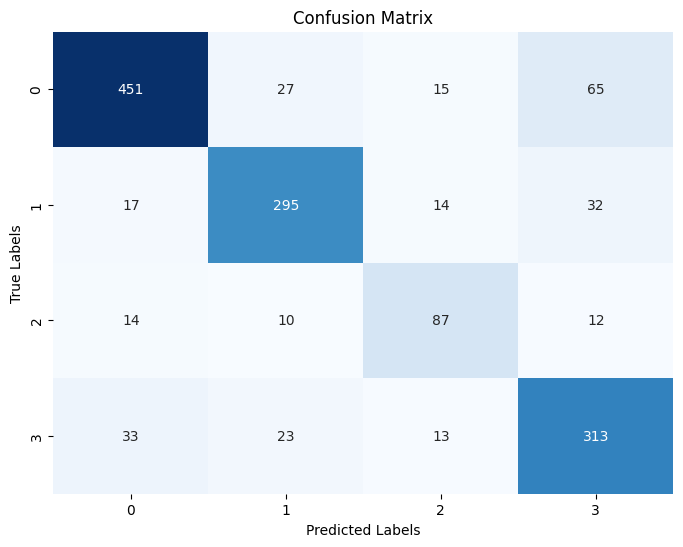

None


In [8]:
# @title BERT Results on train,validation and test

def model_accuracy(data, type):
  predictions = trainer.predict(data)

  predicted_labels = np.argmax(predictions.predictions, axis=1)
  true_labels = data['label']
  accuracy = accuracy_score(true_labels, predicted_labels)
  print(f"**************{type}*************")
  print(f"Accuracy of {type}:", accuracy)
  print(classification_report(true_labels, predicted_labels))
  conf_matrix=confusion_matrix(true_labels, predicted_labels)
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  plt.show()

model_accuracy(train_hg,'Train')
model_accuracy(valid_hg,'Validation')


test_processed_data=[]
for i in test_dataset:
  test_processed_data.append(process_data(i))
test_d = pd.DataFrame(test_processed_data)
test_hg = Dataset(pa.Table.from_pandas(test_d))
print(model_accuracy(test_hg,'test'))


In [9]:
def get_prediction(text, trainer, tokenizer):
    encoding = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
    encoding = {k: v.to(trainer.model.device) for k, v in encoding.items()}
    with torch.no_grad():
        outputs = trainer.model(**encoding)

    logits = outputs.logits
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(logits.squeeze())
    probs = probs.cpu().detach().numpy()
    label = np.argmax(probs, axis=-1)
    if label == 1:
        sentiment = 'Joy'
    elif label == 2:
        sentiment = 'Optimism'
    elif label == 3:
        sentiment = 'Sadness'
    else:
        sentiment = 'Anger'

    return {
        'sentiment': sentiment,
        'probability': probs[label].item(),
        'label': label.item()
    }


In [10]:
# @title From tweet eval samples
val=get_prediction(test_dataset['text'][0],trainer,tokenizer)
print(test_dataset['text'][0])
print(test_dataset['label'][0])
print(val)

val=get_prediction(test_dataset['text'][3],trainer,tokenizer)
print(test_dataset['text'][3])
print(test_dataset['label'][3])
print(val)

val=get_prediction(test_dataset['text'][1],trainer,tokenizer)
print(test_dataset['text'][1])
print(test_dataset['label'][1])
print(val)

#Deppression is real. Partners w/ #depressed people truly dont understand the depth in which they affect us. Add in #anxiety &amp;makes it worse
3
{'sentiment': 'Sadness', 'probability': 0.9958071708679199, 'label': 3}
@user Welcome to #MPSVT! We are delighted to have you! #grateful #MPSVT #relationships
1
{'sentiment': 'Joy', 'probability': 0.9969990253448486, 'label': 1}
@user Interesting choice of words... Are you confirming that governments fund #terrorism? Bit of an open door, but still...
0
{'sentiment': 'Joy', 'probability': 0.9721966981887817, 'label': 1}


In [11]:

for i in test_dataset:
  val=get_prediction(i['text'],trainer,tokenizer)
  print(i['text'])
  print(val)

#Deppression is real. Partners w/ #depressed people truly dont understand the depth in which they affect us. Add in #anxiety &amp;makes it worse
{'sentiment': 'Sadness', 'probability': 0.9958071708679199, 'label': 3}
@user Interesting choice of words... Are you confirming that governments fund #terrorism? Bit of an open door, but still...
{'sentiment': 'Joy', 'probability': 0.9721966981887817, 'label': 1}
My visit to hospital for care triggered #trauma from accident 20+yrs ago and image of my dead brother in it. Feeling symptoms of #depression
{'sentiment': 'Sadness', 'probability': 0.9962788224220276, 'label': 3}
@user Welcome to #MPSVT! We are delighted to have you! #grateful #MPSVT #relationships
{'sentiment': 'Joy', 'probability': 0.9969990253448486, 'label': 1}
What makes you feel #joyful?
{'sentiment': 'Joy', 'probability': 0.9969964027404785, 'label': 1}
i am revolting.
{'sentiment': 'Anger', 'probability': 0.988445520401001, 'label': 0}
Rin might ever appeared gloomy but to be 

In [13]:
# @title For custom sample data
val=get_prediction("I am very happy with the results",trainer,tokenizer)
print(val)
val=get_prediction("This person has no common sense and is very irritating",trainer,tokenizer)
print(val)
val=get_prediction("It is very upsetting to see such a young mind wasted @user @user",trainer,tokenizer)
print(val)

{'sentiment': 'Joy', 'probability': 0.997011661529541, 'label': 1}
{'sentiment': 'Anger', 'probability': 0.9964549541473389, 'label': 0}
{'sentiment': 'Sadness', 'probability': 0.9950172305107117, 'label': 3}
